# Fit Analyses

Jeroen E. Timmerman [](https://orcid.org/0009-0003-8208-0509) (University of Amsterdam)

In [ ]:
library(EMC2)
library(stringr)
library(ggplot2)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: coda

Loading required package: Matrix

************
Welcome to BayesFactor 0.9.12-4.7. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************


Attaching package: 'BayesFactor'

The following object is masked from 'package:EMC2':

    compare

# Upper Censoring

In [ ]:
parsLBA <- c(log(2),3,1,log(2),log(.75),log(.2))
names(parsLBA) <- c("B", "v", "v_lMd", "A", "sv_lMd", "t0")
parsRDM <- c(log(3),1,.4,log(.75),log(.2))
names(parsRDM) <- c("B", "v", "v_lMd", "s_lMd", "t0")
parsLNR <- c(log(.75),log(.65),log(.5),log(.8),log(.4))
names(parsLNR) <- c("m", "m_lMd", "s", "s_lMd", "t0")

In [ ]:
file_names <- list.files("01_simulation/upper_censoring/EMCs")
EMCs <- data.frame()
for (i in file_names){
  load(paste0("01_simulation/upper_censoring/EMCs/", i))
  EMC <- data.frame(EMC = str_remove(i, ".RData"),
                    censoring = str_detect(i, "sM"),
                    model_name = str_extract(i, "LBA|LNR|RDM"),
                    percentage = str_extract(i, "70|90|975")
                    )
  EMCs <- rbind(EMCs, EMC)
}
EMCs <- na.omit(EMCs) # to remove empty sLBA
EMCs$censoring <- factor(EMCs$censoring, c(FALSE, TRUE), c("Truncated", "Censored"))
EMCs$model_name <- factor(EMCs$model_name)
EMCs$percentage <- factor(EMCs$percentage, c(975, 90, 70), c("2.5%", "10%", "30%"))

In [ ]:
pars <- list()
for (i in 1:nrow(EMCs)) {
  pars[[EMCs$EMC[i]]] <- apply(parameters(get(EMCs$EMC[i], envir = globalenv()), selection = "alpha")[,-1], 2, function(x) quantile(x, c(0.025, 0.5, 0.975)))
  EMCs$RMSE[i] <- sqrt(mean((pars[[EMCs$EMC[i]]][2,] - get(paste0("pars", EMCs$model_name[i]), envir = globalenv()))^2))
}

In [ ]:
frequentist <- t.test(RMSE ~ censoring, data = EMCs)
frequentist


    Welch Two Sample t-test

data:  RMSE by censoring
t = 4.4212, df = 9.1973, p-value = 0.001583
alternative hypothesis: true difference in means between group Truncated and group Censored is not equal to 0
95 percent confidence interval:
 0.359907 1.109093
sample estimates:
mean in group Truncated  mean in group Censored 
              0.8440147               0.1095145 

In [ ]:
model <- ttestBF(formula = RMSE ~ censoring, data = EMCs)
model

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 58.5073 ±0%

Against denominator:
  Null, mu1-mu2 = 0 
---
Bayes factor type: BFindepSample, JZS

In [ ]:
#| label: RMSD_upper
#| fig-cap: Root Mean Squared Errors for Upper Censoring in Race Models
#| apa-note: For each model and each level of data missing, the RMSE was computed.

ggplot(EMCs, aes(censoring, RMSE, fill = interaction(percentage, censoring, sep = " "))) +
  facet_grid(~ model_name) +
  scale_fill_brewer(palette = "PuOr") +
  geom_bar(position = "dodge", stat = "identity") +
  labs(fill = "Missing")

In [ ]:
parameters_CI <- as.data.frame(t(data.frame(pars)))
for (i in 1:nrow(parameters_CI)) {
  name <- row.names(parameters_CI)[i]
  parameters_CI$censored[i] <- str_detect(name, "sM")
  parameters_CI$model_name[i] <- str_extract(name, "LBA|LNR|RDM")
  parameters_CI$percentage[i] <- str_extract(name, "70|90|975")
  parameters_CI$parameter[i] <- sub(".*\\.", "", name)
  parameters_CI$true_parameter[i] <- 
    get(paste0("pars", parameters_CI$model_name[i]), envir = globalenv())[parameters_CI$parameter[i]]
}

parameters_CI$percentage <- factor(parameters_CI$percentage, c(975, 90, 70), c("2.5%", "10%", "30%"))
parameters_CI$censored <- factor(parameters_CI$censored, c(TRUE, FALSE), c("Censored", "Truncated"))

In [ ]:
#| label: upper_censoring_recoveries
#| fig-cap: "Upper Censored / Truncated Recoveries at Different Levels"
#| fig-alt: ""
#| apa-note: "Race model recoveries separated by model (LBA, LNR and RDM) and censoring vs truncation. Especially the LBA and LNR parameters are on the identity line for censoring, but off the line for truncation. "

# Use recovery.emc {EMC2} to plot recoveries of a single EMC fit
ggplot(parameters_CI, aes(true_parameter, `50%`, color = percentage)) +
  geom_point() +
  geom_abline() +
  geom_errorbar(aes(ymin = `2.5%`, ymax = `97.5%`)) +
  facet_grid(censored ~ model_name, scales = "free_y") +
  # scale_color_brewer(palette = "YlOrRd") +
  ylab("Estimated Parameters") +
  xlab("True Parameters")

# Censoring Both

In [ ]:
file_names <- list.files("01_simulation/censoring_both/EMCs")
EMCs <- data.frame()
for (i in file_names){
  load(paste0("01_simulation/censoring_both/EMCs/", i))
  EMC <- data.frame(EMC = str_remove(i, ".RData"),
                    censoring = str_detect(i, "sM"),
                    model_name = str_extract(i, "LBA|LNR|RDM"),
                    tail = str_extract(i, "lower|upper|both"),
                    percentage = str_extract(i, "2|10|30|50"),
                    response_known = !str_detect(i, "unknown")
                    )
  assign(EMC$EMC, s)
  EMCs <- rbind(EMCs, EMC)
}

EMCs$censoring <- factor(EMCs$censoring, c(FALSE, TRUE),
                         c("Truncated", "Censored"))
EMCs$model_name <- factor(EMCs$model_name)
EMCs$response_known <- factor(EMCs$response_known, c(FALSE, TRUE),
                              c("unknown", "known"))

In [ ]:
EMCs_expanded <- data.frame()

for (i in 1:nrow(EMCs)) {
  # Retrieve the EMC object for the current row
  emc_data <- get(EMCs$EMC[i], envir = globalenv())
  
  # Extract parameter data (excluding the first column which represents subjects)
  parameter_data <- parameters(emc_data, selection = "alpha")[, -1]
  subject_ids <- parameters(emc_data, selection = "alpha")[, 1]  # Subject column
  
  # Get the list of parameter names
  parameter_names <- colnames(parameter_data)
  
  # Split data by subject
  split_data <- split(parameter_data, subject_ids)
  
  # Compute quantiles and add rows per parameter and subject
  for (subject in names(split_data)) {
    subject_data <- split_data[[subject]]
    
    # Compute quantiles for each parameter
    subject_quantiles <- apply(subject_data, 2, function(x) quantile(x, c(0.25, 0.5, 0.75), na.rm = T))
    
    # Add a row for each parameter
    for (param in parameter_names) {
      EMCs_expanded <- rbind(EMCs_expanded, data.frame(
        EMC = EMCs$EMC[i],
        model_name = EMCs$model_name[i],
        censoring = EMCs$censoring[i],
        tail = EMCs$tail[i],
        percentage = EMCs$percentage[i],
        response_known = EMCs$response_known[i],
        subject = subject,
        parameter_name = param,
        q25 = subject_quantiles[1, param],
        Median = subject_quantiles[2, param],
        q75 = subject_quantiles[3, param],
        true_parameter = get(paste0("pars", EMCs$model_name[i]), envir = globalenv())[param]
      ))
    }
  }
}

(`geom_point()`).

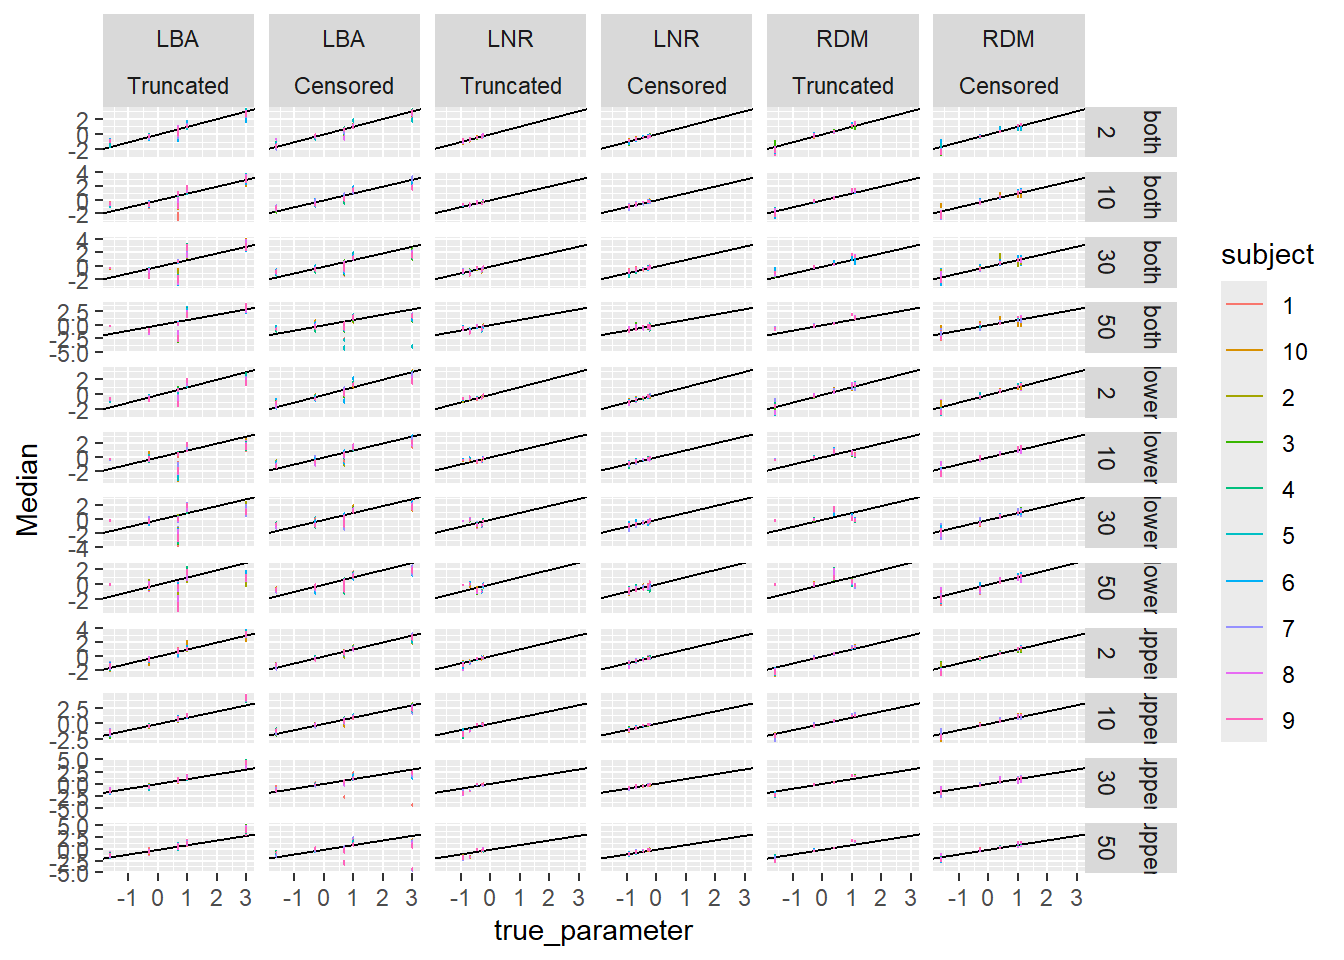

In [ ]:
EMCs_expanded$percentage <- as.numeric(EMCs_expanded$percentage)
EMCs_expanded %>%
  ggplot(aes(true_parameter, Median, color = subject)) +
  geom_point(size = 0.1) +
  geom_abline() +
  facet_grid(tail + percentage ~ model_name + censoring, scales = "free_y") +
  geom_errorbar(aes(ymin = q25, ymax = q75))

In [ ]:
between(parsLBA, EMCs_expanded$q25[EMCs_expanded$EMC == "sMLBAlower2known"][1:6], EMCs_expanded$q75[EMCs_expanded$EMC == "sMLBAlower2known"][1:6])

[1]  TRUE FALSE FALSE FALSE  TRUE  TRUE

In [ ]:
# Calculate RMSE per group
EMCs_RMSEs <- EMCs_expanded %>%
  group_by(subject, EMC, percentage, response_known, 
           tail, censoring, model_name) %>%
  summarise(
    RMSE = sqrt(mean((Median - true_parameter)^2)),  # Calculate RMSE
    .groups = 'drop'  # Ungroup after summarizing
  )

In [ ]:
big_model <- aov(RMSE ~ percentage * response_known *
           tail * censoring * model_name, data = EMCs_RMSEs)

summary(big_model)

                                                      Df Sum Sq Mean Sq F value
percentage                                             1  39.74   39.74 786.596
response_known                                         1   0.26    0.26   5.058
tail                                                   2   7.63    3.81  75.479
censoring                                              1  18.08   18.08 357.993
model_name                                             2  81.76   40.88 809.211
percentage:response_known                              1   0.33    0.33   6.611
percentage:tail                                        2   0.38    0.19   3.737
response_known:tail                                    2   0.46    0.23   4.575
percentage:censoring                                   1   1.50    1.50  29.694
response_known:censoring                               1   0.43    0.43   8.511
tail:censoring                                         2  13.31    6.66 131.753
percentage:model_name                   

In [ ]:
#| label: RMSD_both
#| fig-cap: Root Mean Squared Errors in each condition
#| apa-note: For each model, the RMSE was computed over all subject fits.

na.omit(EMCs_RMSEs) %>%
  ggplot(aes(censoring, RMSE, fill = interaction(percentage, censoring, sep = "% "))) +
  facet_grid(tail + response_known ~ model_name) +
  scale_fill_brewer(palette = "PuOr") +
  stat_summary(position = "dodge", geom = "bar", fun = "mean") +
  labs(fill = "Missing")